In [499]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import iqr
import warnings
warnings.filterwarnings('ignore')

In [500]:
data = []
for d, s, f in os.walk("/Users/jeremypcleung/coding-analytics/7"):
    for subdir in s:
        for directory, subdirectories, files in os.walk("/Users/jeremypcleung/coding-analytics/7/" + subdir):
            for file in files:
                if "." not in file: 
                    current_file=open(os.path.join(directory, file))
                    for line in current_file:
                        if len(line) > 1:
                            data.append(json.JSONDecoder().decode(line))

with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

In [501]:
users = {}
for entry in data:
    if entry["user_id"] not in users:
        users[entry["user_id"]] = []
    users[entry["user_id"]].append(entry)

In [502]:
details = {}
current_users = ['4658', '427', '6234', '6242', '5745', '5362', '5746', '5360', '5508', '6265', '5364', '5242', '6268', '5277', '5363', '6274', '6036', '6277', '6278', '5700', '6144', '5055', '6310', '5332', '6314', '5195', '6317', '6205', '6365', '6535', '6347', '6416', '6576', '6582', '5037', '6345', '6346', '6367', '6599', '6614', '1770', '5729', '5895', '6041', '6079', '6112']
current_levels = ['23','31']

for user_id in users:
    for index in range(len(users[user_id])):
        if users[user_id][index]["content"]["action"] == "Start" and user_id in current_users and users[user_id][index]["content"]["stage_id"] in current_levels:
            current = True
            stage_id = users[user_id][index]["content"]["stage_id"]
            if user_id not in details:
                details[user_id] = {}
            if stage_id not in details[user_id]:
                details[user_id][stage_id] = {"numRuns": 0, "totalDuration": 0, "startToGet": [], "startToRun": [], "numResets": 0, "success": [], "getToPut": []}
            startTime = int(users[user_id][index]["content"]["timestamp"])
            getTime = 0
            runTime = 0
            while(current):
                index += 1
                if len(users[user_id])-1 <= index or ("stage_id" in users[user_id][index]["content"] and users[user_id][index]["content"]["stage_id"] != stage_id):
                    current = False
                    endTime = int(users[user_id][index-1]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Win":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(1)
                elif users[user_id][index]["content"]["action"] == "Leave":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Get":
                    if getTime == 0:
                        getTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToGet"].append(getTime-startTime)
                    getTime = int(users[user_id][index]["content"]["timestamp"])
                elif users[user_id][index]["content"]["action"] == "Put":
                    putTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["getToPut"].append(putTime-getTime)
                elif users[user_id][index]["content"]["action"] == "Run":
                    details[user_id][stage_id]["numRuns"] += 1
                    if runTime == 0:
                        runTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToRun"].append(runTime-startTime)
                elif users[user_id][index]["content"]["action"] == "Reset":
                    details[user_id][stage_id]["numResets"] += 1

In [503]:
delete = []
for index, user_id in enumerate(details):
    for i, stage_id in enumerate(details[user_id]):
        if len(details[user_id][stage_id]["startToGet"])==0 or len(details[user_id][stage_id]["startToRun"])==0 or len(details[user_id][stage_id]["getToPut"])==0:
            delete.append(user_id)

for d in delete:
    del details[d]

In [504]:
stats = np.zeros((len(details),len(current_levels),7))
users_list = []
for index, user_id in enumerate(details):
    users_list.append(user_id)
    for i, stage_id in enumerate(details[user_id]):
        stats[index][i][0] = details[user_id][stage_id]["numRuns"]
        stats[index][i][1] = details[user_id][stage_id]["totalDuration"]
        stats[index][i][2] = np.average(details[user_id][stage_id]["startToGet"])
        stats[index][i][3] = np.average(details[user_id][stage_id]["startToRun"])
        stats[index][i][4] = details[user_id][stage_id]["numResets"]
        stats[index][i][5] = np.average(details[user_id][stage_id]["success"])
        stats[index][i][6] = np.average(details[user_id][stage_id]["getToPut"])  

In [505]:
total = []
q1 = []
q3 = []
iqrVal = []
delete = set()
train = stats
outliers = stats
train_users = users_list
outliers_users = users_list

for index, user in enumerate(stats):
    for ind, stage in enumerate(stats[index]):
        for i, feature in enumerate(stats[index][ind]):
            if len(total)<7:
                total.append([])
            total[i].append(stats[index][ind][i])
            
for i in range(7):
    q1.append(np.percentile(total[i], 25))
    q3.append(np.percentile(total[i], 75))
    iqrVal.append(iqr(total[i]))

for index, user in enumerate(stats):
    for ind, stage in enumerate(stats[index]):
        for i, feature in enumerate(stats[index][ind]):
            if stats[index][ind][i] < q1[i] - 1.5 * iqrVal[i] or stats[index][ind][i] > q3[i] + 1.5 * iqrVal[i]:
                delete.add(index)

delete = list(delete)
train = np.delete(train,delete,axis=0)
outliers = np.take(outliers,delete,axis=0)
train_users = np.delete(train_users,delete,axis=0)
outliers_users = np.take(outliers_users,delete,axis=0)

In [506]:
train = np.reshape(train, (len(train),len(current_levels)*7))
pca = PCA(n_components=2).fit(train)
train_stats = pca.transform(train)
kmeans = KMeans(n_clusters=6, n_init=10, max_iter=300, tol=1e-4)
train_predictions = kmeans.fit_predict(train_stats)

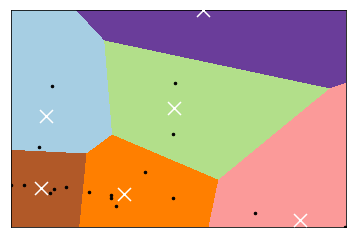

In [507]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = train_stats[:, 0].min() - 1, train_stats[:, 0].max() + 1
y_min, y_max = train_stats[:, 1].min() - 1, train_stats[:, 1].max() + 1

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = ((x_max-x_min)/5000 + (y_max-y_min)/5000)/2     # point in the mesh [x_min, x_max]x[y_min, y_max].

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(train_stats[:, 0], train_stats[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [508]:
outliers = np.reshape(outliers, (len(outliers),len(current_levels)*7))
pca = PCA(n_components=2).fit(outliers)
outliers_stats = pca.transform(outliers)

In [509]:
outliers_predictions = kmeans.predict(outliers_stats)
columns = ["Number of Runs", "Total Duration", "Start to first Get Time", "Start to first Run Time", "Number of Resets", "Success Rate", "Get to Put Time"]
users_df = pd.DataFrame(np.concatenate((train,outliers)), index=np.concatenate((train_users,outliers_users)), columns=np.tile(columns,len(current_levels)))
users_df['Group'] = np.concatenate((train_predictions, outliers_predictions))
users_df.to_csv("users-groups.csv", sep=',')